News publications are becoming increasingly partisan.
Individuals are falling into “echo chambers” online.
Political discourse has become an (opinion poll) point scoring contest.
This results in political entrenchment whereby we no longer see much cross party support on most matters.

I hope to build a programme that allows for users to read a broader range of view by recommending articles that oppose an inputted article by the user.

# Imports

In [61]:
import pandas as pd
import numpy as np
import re

from selenium import webdriver
from selenium.webdriver import Safari
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.keys import Keys
import time

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import string

from imblearn.over_sampling import SMOTE

import sklearn

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)

In [3]:
df = pd.read_csv('newsArticlesWithLabels3.csv')
df['url'][1]

'http://www.huffingtonpost.com/2013/05/21/senate-immigration-bill_n_3315271.html'

1) Url

2) News Type: Has three possible values: other (remember that the articles are sampled from those that are predicted to be political based on our classifiers and so there are false positives we remove based on this label), News, or Opinion.

3) Perceived (whether the worker was looking at the blinded or unblinded version. perceived=1 means unblinded version)

4) Primary topic identified by the worker (If "None", the primary topic is not captured by our list of 14 topics)

5) Secondary topic (If "None", there is no secondary topic or the secondary topic is not captured by our list)

6) Democratic party  vote

7) Republican vote

In [4]:
df_match = df[df['primary.topic'] == df['secondary.topic']]
df_match.reset_index(drop = True, inplace = True)
df_match

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
5,http://www.cnn.com/2013/06/28/politics/obama-c...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
6,http://www.foxnews.com/politics/2013/10/14/ami...,News,0,Civil Rights,Civil Rights,Neutral,SomewhatPositive
7,http://www.bbc.co.uk/news/technology-22213379,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
8,http://www.nbcnews.com/technology/microsoft-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
9,http://radio.foxnews.com/toddstarnes/top-stori...,other,0,Civil Rights,Civil Rights,Neutral,Neutral


## Creating column with publication name

In [5]:
from tld import get_tld
list_of_publications = []
for x in range(0, len(df['url'])):
    res = get_tld(df['url'][x], as_object=True)
    list_of_publications.append(res.domain)
list_of_publications = pd.Series(list_of_publications).unique()
list_of_publications

array(['usatoday', 'huffingtonpost', 'washingtonpost', 'foxnews',
       'breitbart', 'cnn', 'bbc', 'nbcnews', 'dailykos', 'wsj',
       'chicagotribune', 'nytimes', 'latimes', 'reuters', 'yahoo'],
      dtype=object)

# Web Scraping the articles

In [7]:
from newspaper import Article

In [8]:
df_match['text'] = None
for i in df_match.index:
    try:
        article = Article(df_match.loc[i, 'url'])
        article.download()
        article.parse()
        df_match.loc[i, 'text'] = article.text
    except:
        pass

/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1206: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` 

# Cleaning and Exploratory Data Analysis

In [6]:
# df_clean = df_match.copy()
df_clean = pd.read_csv('df_clean.csv')
df_clean

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,text,totalwords
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,Zimmerman verdict renews focus on 'stand your ...,670
1,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"Parts of ObamaCare are starting to fray, even ...",798
2,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,U.S. Immigration Citizenship and Immigration S...,947
3,http://www.cnn.com/2013/06/28/politics/obama-c...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Story highlights Rules let groups like religio...,1069
4,http://www.bbc.co.uk/news/technology-22213379,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Image caption Critics say more must be done to...,333
5,http://www.nbcnews.com/technology/microsoft-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,New disclosures shared by Edward Snowden focus...,912
6,http://www.bbc.co.uk/vietnamese/world/2013/08/...,News,1,Civil Rights,Civil Rights,Positive,Positive,Image caption Lon Snowden (bên phải) và luật ...,488
7,http://www.usatoday.com/story/nation/2013/08/0...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,Tampa socialite Jill Kelley: The saga continue...,447
8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,\n\n\n\n\n\n\n\n\n\n\n\nThe following irrespon...,498
9,http://online.wsj.com/article/SB10001424127887...,Opinion,0,Civil Rights,Civil Rights,Neutral,Neutral,In choosing John Brennan to be the next direct...,76


In [7]:
df_clean.drop(df_clean[df_clean['url'].str.startswith('http://www.huffingtonpost')==True].index, inplace = True)
df_clean.drop(df_clean[df_clean['url'].str.startswith('http://www.washingtonpost')==True].index, inplace = True)
df_clean['totalwords'] = df_clean['text'].str.split().str.len()
df_clean = df_clean.dropna()
df_clean

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,text,totalwords
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,Zimmerman verdict renews focus on 'stand your ...,670
1,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"Parts of ObamaCare are starting to fray, even ...",798
2,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,U.S. Immigration Citizenship and Immigration S...,947
3,http://www.cnn.com/2013/06/28/politics/obama-c...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Story highlights Rules let groups like religio...,1069
4,http://www.bbc.co.uk/news/technology-22213379,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Image caption Critics say more must be done to...,333
5,http://www.nbcnews.com/technology/microsoft-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,New disclosures shared by Edward Snowden focus...,912
6,http://www.bbc.co.uk/vietnamese/world/2013/08/...,News,1,Civil Rights,Civil Rights,Positive,Positive,Image caption Lon Snowden (bên phải) và luật ...,488
7,http://www.usatoday.com/story/nation/2013/08/0...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,Tampa socialite Jill Kelley: The saga continue...,447
8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,\n\n\n\n\n\n\n\n\n\n\n\nThe following irrespon...,498
9,http://online.wsj.com/article/SB10001424127887...,Opinion,0,Civil Rights,Civil Rights,Neutral,Neutral,In choosing John Brennan to be the next direct...,76


In [8]:
df_clean.reset_index(drop = True, inplace = True)
df_clean

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,text,totalwords
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,Zimmerman verdict renews focus on 'stand your ...,670
1,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"Parts of ObamaCare are starting to fray, even ...",798
2,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,U.S. Immigration Citizenship and Immigration S...,947
3,http://www.cnn.com/2013/06/28/politics/obama-c...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Story highlights Rules let groups like religio...,1069
4,http://www.bbc.co.uk/news/technology-22213379,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Image caption Critics say more must be done to...,333
5,http://www.nbcnews.com/technology/microsoft-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,New disclosures shared by Edward Snowden focus...,912
6,http://www.bbc.co.uk/vietnamese/world/2013/08/...,News,1,Civil Rights,Civil Rights,Positive,Positive,Image caption Lon Snowden (bên phải) và luật ...,488
7,http://www.usatoday.com/story/nation/2013/08/0...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,Tampa socialite Jill Kelley: The saga continue...,447
8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,\n\n\n\n\n\n\n\n\n\n\n\nThe following irrespon...,498
9,http://online.wsj.com/article/SB10001424127887...,Opinion,0,Civil Rights,Civil Rights,Neutral,Neutral,In choosing John Brennan to be the next direct...,76


In [9]:
df_clean.to_csv('df_clean.csv', index = False)

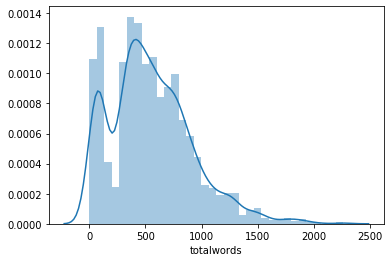

In [10]:
sns.distplot(df_clean['totalwords'])

# NLP Preprocessing

In [11]:
texts = df_clean['text']
texts

0       Zimmerman verdict renews focus on 'stand your ...
1       Parts of ObamaCare are starting to fray, even ...
2       U.S. Immigration Citizenship and Immigration S...
3       Story highlights Rules let groups like religio...
4       Image caption Critics say more must be done to...
5       New disclosures shared by Edward Snowden focus...
6       Image caption Lon Snowden (bên phải) và luật ...
7       Tampa socialite Jill Kelley: The saga continue...
8       \n\n\n\n\n\n\n\n\n\n\n\nThe following irrespon...
9       In choosing John Brennan to be the next direct...
10      But Thursday’s vote resolved only one of sever...
11      SACRAMENTO — “Living in parallel universes,” i...
12      Image caption Miller apologised for "foolish m...
13      John Dos Passos, the novelist and historian, o...
14      Former Secret Service agent Dan Bongino told B...
15      NEW YORK (AP) — Anthony Weiner's ill-fated may...
16      The onetime messiah seems like a sad sack, try...
17      WASHIN

In [12]:
# Removing stopwords
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)
tokens = []
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
for x in range(0, len(texts)):
    tokens.append(nltk.regexp_tokenize(texts[x], pattern))


In [13]:
stopped_tokens = []
for x in range(0, len(tokens)):
    stopped_tokens_raw = [tokens[x][y].lower() for y in range(0, len(tokens[x])) if y not in stopword_list]
    stopped_tokens.append(stopped_tokens_raw)

Condiser Bigrams and Mutual Information Score

In [14]:
lemmy = WordNetLemmatizer()
def apply_lem(doc):
    
    doc_split = doc.split(' ')
    lem_v_doc = ''
    for word in doc_split:
        lem_v_doc += lemmy.lemmatize(word, pos='v') + ' '
        
    doc_split = lem_v_doc.split(' ')
    lem_doc = ''
    for word in doc_split:
        lem_doc += lemmy.lemmatize(word, pos='a') + ' '
        
    return lem_doc

In [15]:
lem_text = []
for x in range(0, len(texts)):
    lem_text.append(apply_lem(texts[x]))

In [16]:
lem_text[0]

'Zimmerman verdict renew focus on \'stand your ground\' laws\n\nThe acquittal of George Zimmerman in the kill of unarm teen Trayvon Martin in Sanford, Fla., raise fresh discussion of "stand your ground" laws.\n\nThe case center around whether Zimmerman act in self defense and draw national attention to Florida\'s law, which allow people to defend themselves with force if they feel threaten in their home, business, car, or a place where they "have a legal right to be." At least 22 state have a similar law, accord to the National Conference of State Legislatures.\n\nWhile Zimmerman do not ultimately use the "stand your ground" defense in his case, Sanford police do not arrest him until almost two months after the shoot because of the Florida stand your grind rule that require police to have specific evidence to refute a self defense claim in order to arrest someone claim self defense.\n\nThat provision of the law "does a disservice to Floridians because it\'s so vague," say Florida Sen. 

In [17]:
print("ORIGINAL: \n\n", texts[0])
print('\n')
print("LEMMED: \n\n", lem_text[0])

ORIGINAL: 

 Zimmerman verdict renews focus on 'stand your ground' laws

The acquittal of George Zimmerman in the killing of unarmed teen Trayvon Martin in Sanford, Fla., raised fresh discussion of "stand your ground" laws.

The case centered around whether Zimmerman acted in self defense and drew national attention to Florida's law, which allows people to defend themselves with force if they feel threatened in their home, business, car, or a place where they "have a legal right to be." At least 22 states have a similar law, according to the National Conference of State Legislatures.

While Zimmerman did not ultimately use the "stand your ground" defense in his case, Sanford police did not arrest him until almost two months after the shooting because of the Florida stand your ground rules that require police to have specific evidence to refute a self defense claim in order to arrest someone claiming self defense.

That provision of the law "does a disservice to Floridians because it's 

In [18]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)
tf_idf_vect = TfidfVectorizer(lowercase=True, tokenizer = tokenizer.tokenize, 
                              stop_words=stopword_list, ngram_range=(1,3),
                             min_df = 0.025,
                             max_df = 0.9)

In [19]:
x_lem_tfidf_sparse = tf_idf_vect.fit_transform(lem_text)

In [20]:
x_lem_tfidf = pd.DataFrame(x_lem_tfidf_sparse.toarray(), columns=tf_idf_vect.get_feature_names())

In [21]:
for i, col in enumerate(x_lem_tfidf.columns):
    print(i, col)

0 000
1 1
2 10
3 10 years
4 100
5 11
6 11 million
7 12
8 13
9 14
10 15
11 16
12 17
13 18
14 19
15 2
16 20
17 20 years
18 200
19 2000
20 2001
21 2004
22 2005
23 2006
24 2007
25 2008
26 2009
27 2010
28 2011
29 2012
30 2013
31 2013 reuters
32 2014
33 2016
34 21
35 22
36 23
37 24
38 25
39 26
40 27
41 28
42 29
43 3
44 30
45 300
46 31
47 35
48 4
49 40
50 400
51 45
52 46
53 47
54 48
55 5
56 50
57 500
58 55
59 6
60 60
61 7
62 7 years
63 7 years ago
64 70
65 8
66 80
67 9
68 90
69 abc
70 ability
71 able
72 absolutely
73 abuse
74 accept
75 access
76 accord
77 according
78 account
79 accountable
80 accuse
81 achieve
82 acknowledge
83 across
84 across country
85 act
86 action
87 active
88 activists
89 activities
90 activity
91 actually
92 add
93 added
94 addition
95 additional
96 address
97 administration
98 admit
99 adopt
100 adults
101 advance
102 advertisement
103 advice
104 advocacy
105 advocate
106 affairs
107 affect
108 affordable
109 affordable care
110 affordable care act
111 afghanistan
11

In [22]:
x_lem_tfidf.columns[200:250]

Index(['audience', 'august', 'author', 'authorities', 'authority', 'available',
       'average', 'avoid', 'award', 'aware', 'away', 'b', 'back', 'background',
       'bad', 'balance', 'ban', 'bank', 'bar', 'barack', 'barack obama',
       'base', 'based', 'basic', 'basis', 'battle', 'bear', 'beat', 'become',
       'begin', 'behalf', 'behavior', 'behind', 'believe', 'benefit',
       'benefits', 'best', 'better', 'beyond', 'bid', 'biden', 'big', 'bill',
       'bill clinton', 'bill would', 'billion', 'bills', 'bipartisan', 'bite',
       'black'],
      dtype='object')

In [23]:
df_clean['bias'] = df_clean['democrat.vote'].str.contains('Positive').astype(int) - df_clean['republican.vote'].str.contains('Positive').astype(int) - df_clean['democrat.vote'].str.contains('Negative') + df_clean['republican.vote'].str.contains('Negative')
df_clean

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,text,totalwords,bias
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,Zimmerman verdict renews focus on 'stand your ...,670,0
1,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"Parts of ObamaCare are starting to fray, even ...",798,0
2,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,U.S. Immigration Citizenship and Immigration S...,947,0
3,http://www.cnn.com/2013/06/28/politics/obama-c...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Story highlights Rules let groups like religio...,1069,0
4,http://www.bbc.co.uk/news/technology-22213379,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,Image caption Critics say more must be done to...,333,0
5,http://www.nbcnews.com/technology/microsoft-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,New disclosures shared by Edward Snowden focus...,912,0
6,http://www.bbc.co.uk/vietnamese/world/2013/08/...,News,1,Civil Rights,Civil Rights,Positive,Positive,Image caption Lon Snowden (bên phải) và luật ...,488,0
7,http://www.usatoday.com/story/nation/2013/08/0...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,Tampa socialite Jill Kelley: The saga continue...,447,0
8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,\n\n\n\n\n\n\n\n\n\n\n\nThe following irrespon...,498,2
9,http://online.wsj.com/article/SB10001424127887...,Opinion,0,Civil Rights,Civil Rights,Neutral,Neutral,In choosing John Brennan to be the next direct...,76,0


In [24]:
bias = []
for x in range(0, len(df_clean['bias'])):
    try:
        if df_clean['bias'][x] < 0:
            bias.append(-1)
        elif df_clean['bias'][x] > 0:
            bias.append(1) 
        elif df_clean['bias'][x] == 0:
            bias.append(0)
        else:
            pass
    except:
        pass
bias = pd.Series(bias)
bias

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       1
9       0
10      0
11     -1
12     -1
13     -1
14     -1
15     -1
16     -1
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      1
25      0
26      0
27      0
28      1
29      0
       ..
2266   -1
2267    0
2268    0
2269    0
2270    0
2271    0
2272    0
2273    0
2274   -1
2275    0
2276    0
2277   -1
2278    0
2279    0
2280    0
2281    0
2282   -1
2283    0
2284    0
2285    0
2286    0
2287    0
2288    0
2289    1
2290    0
2291    0
2292    0
2293    0
2294    1
2295    1
Length: 2296, dtype: int64

# Modelling

In [38]:
class Classification():
    
    def __init__(self, model, x_train, x_val, y_train, y_val):
        self.model = model
        self.x_train = x_train
        self.x_val = x_val
        self.y_train = y_train
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model == 'Decision Tree':
            self.fitting = DecisionTreeClassifier(random_state = 42)
        elif self.model == 'Random Forest':
            self.fitting = RandomForestClassifier(n_estimators = 10, 
                                                    n_jobs = -1, random_state=42)
        elif self.model == 'SVM':
            self.fitting = SVC(decision_function_shape = 'ovr', random_state = 42)
        elif self.model == 'Logistic Regression':
            self.fitting = LogisticRegression(fit_intercept = True, multi_class = 'multinomial')
#         elif Naive Bayes <-------

            
    def scores(self,model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]

        acc_train = accuracy_score(y_train,train_prob)
        acc_val = accuracy_score(y_val,val_prob)

        self.acc_train = acc_train
        self.acc_val = acc_val

        self.scores_table["Model Name"] = [self.model]
        self.scores_table["Train Accuracy"] = [self.acc_train]
        self.scores_table["Validation Accuracy"] = [self.acc_val]

        return self.scores_table


    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k %50 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
    
    
    def roc_plot(model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
            fpr, tpr, threshold = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, threshold)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()
        

    def get_scores(self,param_grid,cv_type):
        reg = self.fitting
#         fit_reg = reg.fit(self.x_train,self.y_train)
        opt_model = GridSearchCV(reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='accuracy',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.x_train,self.y_train) 
        self.best_model = opt_model.best_estimator_
#         self.scores = Classification.scores(self,self.best_model,
#                                             self.x_train,self.x_val,
#                                             self.y_train,self.y_val)
        self.best_params = opt_model.best_params_
#         display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
#         self.roc_plot = Classification.roc_plot(self.best_model,
#                                                 self.x_train,self.x_val,
#                                                 self.y_train,self.y_val)
        self.y_tested = opt_model.predict(self.x_val)
        accuracy = accuracy_score(self.y_val, self.y_tested)
        print("Accuracy score: ", accuracy, '\n')
        
        
    def opt_plots(self):
        if self.model == "Decision Tree" or self.model == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params,opt[cols]],axis=1,sort=False)

            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
        else:
            print("This model does not have an optimum hyperparameter plot!")
            
            
    def conf_matrix(y_true, y_pred):
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

        for ind, label in enumerate(y_true):
            pred = y_pred[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1

        return cm
    
    
    def show_conf_matrix(self):
        Classification.conf_matrix(self.y_val, self.y_tested)
        cnf_matrix = confusion_matrix(self.y_val, self.y_tested)

        plt.figure(figsize=(7,7))
        plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)

        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar
        
        
    def plot_decision_tree(self):
        if self.model == "Decision Tree":
            plt.figure(figsize=(22,22))
            tree.plot_tree(self.best_model.fit(self.x_train,self.y_train))
        else:
            print("This model does not have a decision tree plot!")
            
            
    def threshold_selection(self, prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y_train, y_test):
        fpr, tpr, thresholds = roc_curve(self.y_train, self.y_test)
        m = ((1 - prevalence) / prevalence) * ((CostFP_minus_CostTN) / (CostFN_minus_CostTP))
        fm_thresholds = []
        for i in range(len(fpr)):
            fm = tpr[i] - (m * fpr[i])
            fm_thresholds.append((thresholds[i], fm))
        fm_thresholds = sorted(fm_thresholds, key=lambda fm_value: fm_value[1], reverse=True)
        return fm_thresholds[0][0]
    
#     def svm_predict
        
        
        
        

In [26]:
# SMOTE - to correct for imbalanced class
print('Original class distribution: \n')
print(bias.value_counts())
smote = SMOTE()
X, y = smote.fit_sample(x_lem_tfidf, bias) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y).value_counts())

Original class distribution: 

 0    1644
 1     386
-1     266
dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

-1    1644
 1    1644
 0    1644
dtype: int64


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)

In [28]:
skf = StratifiedKFold(n_splits=5)

## Logistic Regression

The best hyperparameters are:  {'C': 25, 'penalty': 'l2', 'solver': 'saga'} 

Accuracy score:  0.8572972972972973 



/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


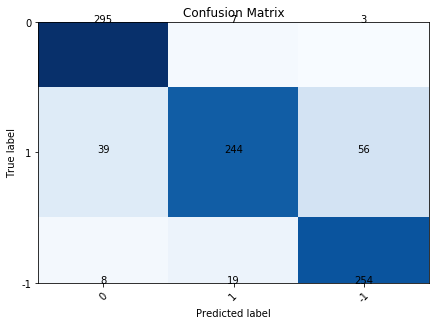

In [29]:
logistic = Classification('Logistic Regression', X_train_v, X_val, y_train_v, y_val)

param_grid = {"penalty":['l1', 'l2', 'elasticnet', 'none'],            # l1 and l2 are different type of penalties
              "solver" :['saga'],  # Algorithm to use in the optimization problem
              "C":[0.5, 1, 5, 10, 25]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

The best hyperparameters are:  {'C': 25, 'penalty': 'l2', 'solver': 'saga'} 

Accuracy score:  0.8562162162162162 



/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


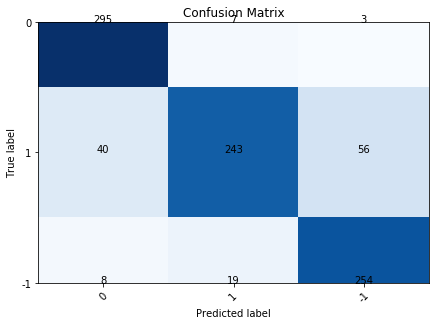

In [30]:
logistic = Classification('Logistic Regression', X_train_v, X_val, y_train_v, y_val)

param_grid = {"penalty":['l2'],            # l1 and l2 are different type of penalties
              "solver" :['saga'],  # Algorithm to use in the optimization problem
              "C":[20, 25, 30]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

The best hyperparameters are:  {'C': 22, 'penalty': 'l2', 'solver': 'saga'} 

Accuracy score:  0.8583783783783784 



/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


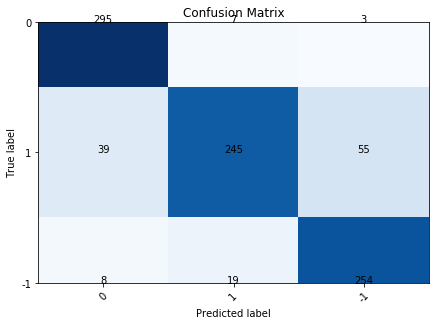

In [31]:
logistic = Classification('Logistic Regression', X_train_v, X_val, y_train_v, y_val)

param_grid = {"penalty":['l2'],            # l1 and l2 are different type of penalties
              "solver" :['saga'],  # Algorithm to use in the optimization problem
              "C":[18, 20, 22]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

## SVM

/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The best hyperparameters are:  {'C': 1, 'kernel': 'rbf'} 

Accuracy score:  0.9005405405405406 



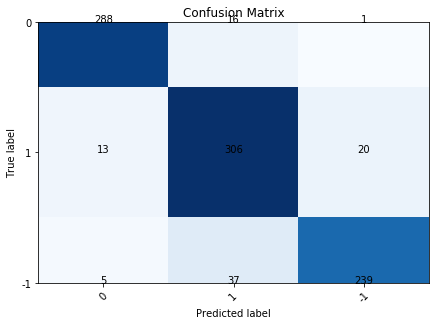

In [32]:
svm = Classification('SVM', X_train_v, X_val, y_train_v, y_val)

param_grid = {"kernel":['linear', 'poly', 'rbf', 'sigmoid'],
              "C":[1, 5, 20]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

svm.get_scores(param_grid,skf)
svm.show_conf_matrix()

/Users/nielsclausen/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The best hyperparameters are:  {'C': 2, 'kernel': 'rbf'} 

Accuracy score:  0.907027027027027 



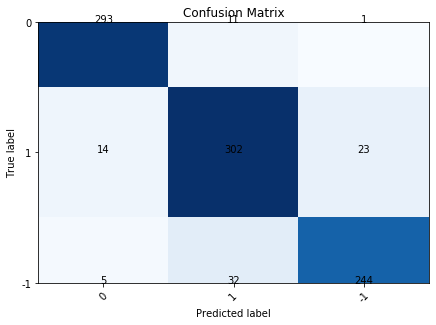

In [33]:
svm = Classification('SVM', X_train_v, X_val, y_train_v, y_val)

param_grid = {"kernel":['linear', 'poly', 'rbf', 'sigmoid'],
              "C":[0.5, 1, 2, 5]}

svm.get_scores(param_grid,skf)
svm.show_conf_matrix()

The best hyperparameters are:  {'C': 1.5, 'kernel': 'rbf'} 

Accuracy score:  0.907027027027027 



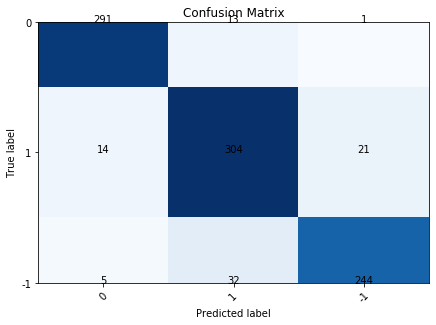

In [34]:
svm = Classification('SVM', X_train_v, X_val, y_train_v, y_val)

param_grid = {"kernel":['linear', 'poly', 'rbf', 'sigmoid'],
              "C":[1.5, 2, 2.5, 3]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization

svm.get_scores(param_grid,skf)
svm.show_conf_matrix()

The best hyperparameters are:  {'C': 1.25, 'kernel': 'rbf'} 

Accuracy score:  0.907027027027027 



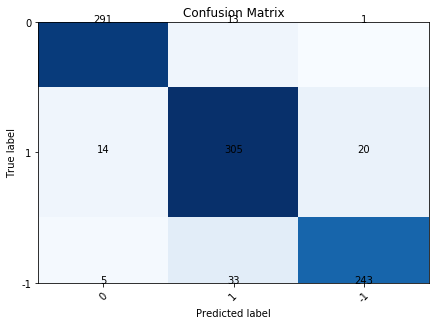

In [45]:
svm = Classification('SVM', X_train_v, X_val, y_train_v, y_val)

param_grid = {"kernel":['linear', 'poly', 'rbf', 'sigmoid'],
              "C":[1, 1.25, 1.5, 1.75]}           # Inverse of regularization strength; must be a positive float. in support vector machines, smaller values specify stronger regularization

svm.get_scores(param_grid,skf)
svm.show_conf_matrix()

## Random Forest

The best hyperparameters are:  {'max_depth': 25, 'min_samples_leaf': 1} 

Accuracy score:  0.8172972972972973 



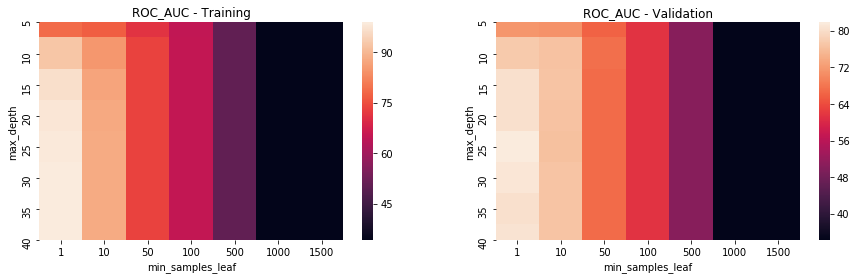

In [36]:
ran_forest = Classification('Random Forest',X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[5,10,15,20,25,30,35,40],           # The maximum depth of the tree
              'min_samples_leaf':[1,10,50,100,500,1000,1500]} # The minimum number of samples required to be at a leaf node

ran_forest.get_scores(param_grid,skf)
ran_forest.opt_plots()

The best hyperparameters are:  {'max_depth': 35, 'min_samples_leaf': 3} 

Accuracy score:  0.827027027027027 



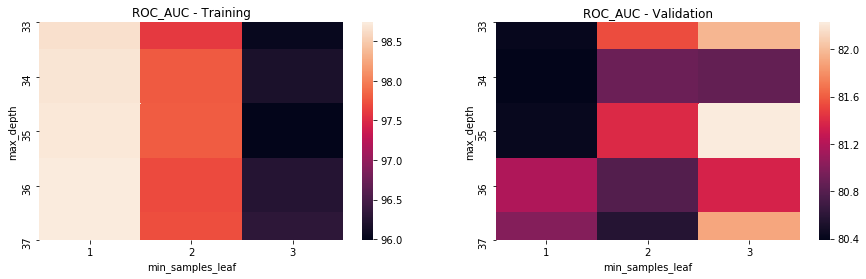

In [37]:
ran_forest = Classification('Random Forest',X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[33,34,35,36,37],           # The maximum depth of the tree
              'min_samples_leaf':[1,2,3]} # The minimum number of samples required to be at a leaf node

ran_forest.get_scores(param_grid,skf)
ran_forest.opt_plots()

In [53]:
x_lem_tfidf.iloc[0,:]

000              0.000000
1                0.000000
10               0.000000
10 years         0.000000
100              0.000000
11               0.000000
11 million       0.000000
12               0.000000
13               0.000000
14               0.000000
15               0.000000
16               0.000000
17               0.000000
18               0.000000
19               0.000000
2                0.000000
20               0.000000
20 years         0.000000
200              0.000000
2000             0.000000
2001             0.000000
2004             0.000000
2005             0.043638
2006             0.000000
2007             0.000000
2008             0.000000
2009             0.000000
2010             0.000000
2011             0.000000
2012             0.000000
                   ...   
witness          0.000000
woman            0.000000
women            0.000000
wonder           0.000000
word             0.000000
words            0.000000
work             0.000000
worker      

In [106]:
def suggest(prediction):    
    if prediction == 0:
        neutral = []
        neutral.append(df_clean.loc[df_clean['bias'] > 0].sample(n=1))
        neutral.append(df_clean.loc[df_clean['bias'] < 0].sample(n=1))
        neutral = pd.concat(neutral)
        return neutral
    elif prediction < 0:
        right = []
        right.append(df_clean.loc[df_clean['bias'] > 0].sample(n=1))
        right.append(df_clean.loc[df_clean['bias'] == 0].sample(n=1))
        right = pd.concat(right)
        return right
    elif prediction > 0:
        left = []
        left.append(df_clean.loc[df_clean['bias'] < 0].sample(n=1))
        left.append(df_clean.loc[df_clean['bias'] == 0].sample(n=1))
        left = pd.concat(left)
        return left

In [107]:
prediction = svm.best_model.predict([x_lem_tfidf.iloc[13,:]])
suggest(prediction)

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,text,totalwords,bias
710,http://www.dailykos.com/story/2013/11/22/12575...,Opinion,0,None,None,Neutral,Negative,Sen. Susan Collins (R-ME)\n\nSen. Susan Collin...,283,1
446,http://www.usatoday.com/story/sports/ncaaf/201...,other,0,None,None,Neutral,Neutral,New Mexico Bowl: Colorado State vs. Washington...,221,0


In [57]:
svm.__dict__

{'model': 'SVM',
 'x_train':            000         1        10  10 years       100        11  11 million        12        13  ...     years  years ago       yes       yet      york  york city  york times     young  young people
 347   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000  0.061510  0.129969  ...  0.136606   0.000000  0.000000  0.000000  0.000000   0.000000    0.000000  0.000000      0.000000
 894   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  ...  0.000000   0.000000  0.000000  0.064313  0.000000   0.000000    0.000000  0.000000      0.000000
 2168  0.000000  0.043260  0.000000  0.000000  0.000000  0.034656    0.000000  0.019598  0.000000  ...  0.010881   0.000000  0.000000  0.017970  0.097437   0.026308    0.000000  0.000000      0.000000
 3801  0.000000  0.026323  0.016797  0.000000  0.000000  0.000000    0.000000  0.000000  0.000000  ...  0.008493   0.000000  0.000000  0.000000  0.000000   0.000000    

In [44]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

step 1: bag of words
step 2: word embeddings
step 3: 